<a href="https://colab.research.google.com/github/BrouthenKamel/Auto-CL/blob/main/Rubik_Cube_PPO_with_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [ ]:
!pip install -U dm-haiku

In [ ]:
!pip install rlax jumanji

# PPO

## Import

In [31]:
import jumanji
import jumanji.wrappers
from jumanji.environments.logic.rubiks_cube import generator as rubik_generator

import haiku as hk
import jax
from jax.nn import one_hot
import jax.numpy as jnp

import chex
import optax
import rlax
import distrax

import abc
from functools import partial
from typing import List, Callable
from pathlib import Path
from collections import deque
from collections.abc import Iterable

import matplotlib.pyplot as plt

import pickle

## Model

In [32]:
class DiscreteModel(hk.Module):

    def __init__(self, num_actions: int):
        super().__init__()
        self.num_actions = num_actions

    def __call__(self, observation):

        x = hk.Conv3D(64, (3, 2, 2), padding="VALID", stride=1)(observation)
        x = hk.Conv3D(32, (3, 2, 2), padding="VALID", stride=1)(x)
        x = hk.Flatten()(x)
        x = hk.Sequential([
            hk.Linear(64), jax.nn.relu,
            hk.Linear(128), jax.nn.relu,
            hk.Linear(128), jax.nn.relu,
            hk.Linear(64), jax.nn.relu,
        ])(x)

        action_logtis = hk.Linear(self.num_actions)(x)

        value = hk.Sequential([
            hk.Linear(128), jax.nn.relu,
            hk.Linear(64), jax.nn.relu,
            hk.Linear(32), jax.nn.relu,
            hk.Linear(1), jax.nn.tanh
        ])(x)

        return action_logtis, value

## Utils

### Data classes

In [33]:
@chex.dataclass
class Transition:
    observation: chex.ArrayDevice
    action: int
    reward: float
    done: int
    next_observation: chex.ArrayDevice
    logits: chex.ArrayDevice
    log_pi: float
    state_value: chex.ArrayDevice
    advantage: float = None
    step_return: float = None


@chex.dataclass
class AgentState:
    params: hk.Params
    optimizer_state: optax.OptState


@chex.dataclass
class EpisodeStats:
    reward: int = 0
    num_steps: int = 0


@chex.dataclass
class TrainingStats:
    loss: float
    value_loss: float
    policy_loss: float
    entropy_loss: float

### Builders

In [34]:
class EpisodeStatsBuilder:

    def __init__(self):
        self._stats = EpisodeStats()

    def add(self, **kwargs):
        self._stats.num_steps += 1
        self._stats.reward += float(kwargs["reward"])

    def get(self):
        return self._stats

In [35]:
def make_agent_state(env, model_factory: hk.Module, lr: float, rng_key: chex.Array, device):
    with jax.default_device(device):
        init, apply = hk.without_apply_rng(hk.transform(model_factory))

        dummy_obs = env.reset()
        dummy_obs = refactor_obs(dummy_obs)

        params = init(rng=rng_key, x=dummy_obs[None, ...])

        optimizer = optax.adam(learning_rate=lr)
        optimizer_state = optimizer.init(params)

        return apply, optimizer.update, AgentState(params=params, optimizer_state=optimizer_state)

## Rollout

In [36]:
class RolloutBuffer:

    def __init__(self, batch_size: int, num_batches: int, discount_gamma: int, gae_lambda: int, use_gae: bool):
        self._transitions: List[Transition] = []
        self._discount_gamma = discount_gamma
        self._gae_lambda = gae_lambda
        self._batch_size = batch_size
        self._num_batches = num_batches
        self._use_gae = use_gae

    def reset(self):
        self._transitions = []

    def add(self, transition: Transition):
        if isinstance(transition, list):
            self._transitions.extend(transition)
        else:
            self._transitions.append(transition)

    @partial(jax.jit, static_argnums=0)
    def preprocess(self, rng_key, transitions):
        transitions = jax.tree_util.tree_map(lambda *t: jnp.asarray(t), *transitions)
        transitions.state_value = jax.lax.stop_gradient(transitions.state_value)

        discount_t = (1 - transitions.done) * self._discount_gamma

        if self._use_gae:
            extended_values = jnp.append(transitions.state_value, 0)
            transitions.advantage = rlax.truncated_generalized_advantage_estimation(
                r_t=transitions.reward,
                discount_t=discount_t,
                lambda_=self._gae_lambda,
                values=extended_values,
                stop_target_gradients=True
            )
            transitions.step_return = transitions.advantage + transitions.state_value
        else:
            transitions.step_return = rlax.discounted_returns(
                r_t=transitions.reward,
                discount_t=discount_t,
                v_t=0.0,
            )

            transitions.advantage = transitions.step_return - transitions.state_value

        transitions = jax.tree_util.tree_map(lambda t: jax.random.permutation(key=rng_key, x=t), transitions)
        transitions = jax.tree_util.tree_map(
            lambda t:
            t[:self._batch_size * self._num_batches].reshape(self._num_batches, self._batch_size, -1).squeeze(),
            transitions
        )

        transitions.observation = transitions.observation[:self._batch_size * self._num_batches].reshape(self._num_batches, self._batch_size, 6,3,3,6).squeeze()

        return transitions

    def get(self, rng_key):
        return self.preprocess(rng_key, self._transitions)

    def __len__(self):
        return len(self._transitions)


## Policy

### Base

In [37]:
class BasePPOPolicy(abc.ABC):

    def __init__(
            self,
            apply_fun: Callable,
            opt_update_fun: Callable,
            policy_clip: float,
            entropy_coefficient: float,
            value_coefficient: float,
            apply_value_clipping: bool = False,
            value_clip: int = 0.2
    ):
        self.apply_fun = apply_fun
        self._opt_update_fun = opt_update_fun
        self.policy_clip = policy_clip
        self.entropy_coefficient = entropy_coefficient
        self.value_coefficient = value_coefficient
        self._apply_value_clipping = apply_value_clipping
        self._value_clip = value_clip

    def get_importance_sampling_ratios(self, transitions, params):
        raise NotImplementedError()

    def get_entropy_loss(self, transitions, logits):
        raise NotImplementedError()

    def loss(self, params: hk.Params, transitions: Transition):
        ratio, new_logits, new_values = self.get_importance_sampling_ratios(transitions, params)

        advantage = jax.nn.standardize(transitions.advantage)

        policy_loss = rlax.clipped_surrogate_pg_loss(
            prob_ratios_t=ratio,
            adv_t=advantage,
            epsilon=self.policy_clip
        )

        targets = jax.nn.standardize(transitions.step_return)
        value_loss = rlax.l2_loss(
            predictions=jnp.squeeze(new_values),
            targets=targets
        )

        if self._apply_value_clipping:
            vf_clipped = transitions.state_value + jnp.clip(
                new_values - transitions.state_value,
                -self._value_clip,
                self._value_clip
            )

            value_loss_2 = rlax.l2_loss(
                predictions=jnp.squeeze(vf_clipped),
                targets=transitions.step_return
            )

            value_loss = jnp.minimum(value_loss, value_loss_2)

        value_loss = jnp.mean(value_loss)

        entropy_loss = self.get_entropy_loss(transitions, new_logits)

        loss_value = policy_loss + self.value_coefficient * value_loss + self.entropy_coefficient * entropy_loss

        return loss_value, (policy_loss, value_loss, entropy_loss)

    def update(self, transitions: Transition, agent_state: AgentState):
        (loss_value, (policy_loss, value_loss, entropy_loss)), grad = jax.value_and_grad(self.loss, has_aux=True)(
            agent_state.params, transitions
        )
        updates, new_opt_state = self._opt_update_fun(grad, agent_state.optimizer_state)
        new_params = optax.apply_updates(params=agent_state.params, updates=updates)

        training_stats = TrainingStats(
            loss=loss_value,
            policy_loss=policy_loss,
            value_loss=value_loss,
            entropy_loss=entropy_loss,
        )

        agent_state = AgentState(params=new_params, optimizer_state=new_opt_state)
        return agent_state, training_stats

    @abc.abstractmethod
    def act(self, observation: chex.ArrayNumpy, params: hk.Params, rng_key: chex.Array):
        pass

### discrete

In [38]:
class DiscretePPOPolicy(BasePPOPolicy):

    def get_importance_sampling_ratios(self, transitions, params):
        new_logits, new_values = self.apply_fun(params, transitions.observation)
        ratio = distrax.importance_sampling_ratios(
            target_dist=distrax.Categorical(new_logits),
            sampling_dist=distrax.Categorical(transitions.logits),
            event=transitions.action
        )
        return ratio, new_logits, new_values

    def get_entropy_loss(self, transitions, logits):
        return -jnp.mean(distrax.Softmax(logits).entropy())

    @partial(jax.jit, static_argnums=0)
    def act(self, observation: chex.ArrayNumpy, params: hk.Params, rng_key: chex.Array, explore=True):
        def sample(rng_key):
            return distribution.sample_and_log_prob(seed=rng_key)

        def deterministic_sample(*_):
            action = distribution.mode()
            log_pi = distribution.log_prob(action)

            return action, log_pi

        logits, state_value = self.apply_fun(params, observation[None, ...])
        logits, state_value = jnp.squeeze(logits), jnp.squeeze(state_value)

        distribution = distrax.Categorical(logits=logits)
        action, log_pi = jax.lax.cond(explore, true_fun=sample, false_fun=deterministic_sample, operand=rng_key)

        return action, logits, log_pi, state_value

# Trainer

In [39]:
class PPOTrainer:
    """
    The PPO trainer handles the evaluation and update loop of the PPO algorithm
    """

    def __init__(
            self,
            policy_class,
            env_factory: Callable,
            agent_state_factory: Callable,
            num_iteration: int,
            num_sgd_iteration: int,
            learning_rate: float,
            policy_clip: float,
            entropy_coefficient: float,
            value_coefficient: float,
            batch_size: int,
            num_batches: int,
            discount_gamma: float,
            gae_lambda: float,
            value_clip: float,
            use_gae: bool,
            apply_value_clipping: bool,
            n_scrambles_param,
            explore=True,
            max_iter_steps=20,
            deque_length=10,
            evaluation_device: str = "gpu",
            training_device: str = "gpu",
            checkpoint_freq: int = 25,
            checkpoint_dir: str = "checkpoints",
            render: bool = False,
    ):

        self._policy_cls = policy_class

        self._env_factory = env_factory
        self._n_scrambles_param = n_scrambles_param
        self._max_iter_steps = max_iter_steps

        self._num_sgd_iteration = num_sgd_iteration
        self._num_iteration = num_iteration
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        self._num_batches = num_batches
        self._discount_gamma = discount_gamma
        self._gae_lambda = gae_lambda
        self._policy_clip = policy_clip
        self._entropy_coefficient = entropy_coefficient
        self._value_coefficient = value_coefficient

        self._agent_state_factory = agent_state_factory
        self._use_gae = use_gae
        self._apply_value_clipping = apply_value_clipping
        self._value_clip = value_clip

        self._explore = explore

        self._checkpoint_freq = checkpoint_freq
        self._checkpoint_dir = checkpoint_dir

        self._rewards = {
            "record": jnp.array([]),
            "reward_deque": deque(maxlen=deque_length)}

        self._losses = {
            "record" : {
                "loss": jnp.array([]),
                "value_loss": jnp.array([]),
                "entropy_loss": jnp.array([]),
                "policy_loss": jnp.array([])
            },
            "loss_deque" : {
                "loss": deque(maxlen=deque_length),
                "value_loss": deque(maxlen=deque_length),
                "entropy_loss": deque(maxlen=deque_length),
                "policy_loss": deque(maxlen=deque_length)
            }}

        self._render = render

        if(isinstance(n_scrambles_param, int)):
          self._n_scrambles = n_scrambles_param
          self._env = env_factory(n_scrambles=self._n_scrambles)
        else:
          self._n_scrambles = n_scrambles_param[0]
          self._env = env_factory(n_scrambles=self._n_scrambles)


        self._buffer = RolloutBuffer(
            discount_gamma=self._discount_gamma,
            gae_lambda=self._gae_lambda,
            batch_size=self._batch_size,
            num_batches=self._num_batches,
            use_gae=self._use_gae
        )
        [*_, self._train_device], [*_, self._eval_device] = jax.devices(training_device), jax.devices(evaluation_device)

    def _run_policy_evaluation(self, iteration, policy: BasePPOPolicy, agent_state: AgentState, seed: jnp.array, device):

        with jax.default_device(device):
            agent_state = jax.device_put(agent_state, device)
            self._buffer.reset()
            episodes_stats = []
            while len(self._buffer) < self._batch_size * self._num_batches:
                seed, episode_seed = jax.random.split(seed)
                transitions, episode_stats = self.run_single_episode(iteration, policy, agent_state, episode_seed, self._explore)
                self._buffer.add(transitions)
                episodes_stats.append(episode_stats)

            return self._buffer, episodes_stats

    def _run_policy_update(self, transitions, policy: BasePPOPolicy, agent_state: AgentState, device):

        @jax.jit
        def _train(agent_state, transitions):
            agent_state, training_stats = jax.lax.scan(
                f=lambda a, _: _train_single_iteration(a, transitions),
                init=agent_state,
                xs=jnp.arange(self._num_sgd_iteration)
            )
            training_stats = jax.tree_util.tree_map(lambda t: jnp.mean(t, axis=-1), training_stats)
            return agent_state, training_stats

        def _train_single_iteration(agent_state, transitions):
            agent_state, iteration_training_stats = jax.lax.scan(_train_single_batch, init=agent_state, xs=transitions)
            iteration_training_stats = jax.tree_util.tree_map(lambda t: jnp.mean(t, axis=-1), iteration_training_stats)
            return agent_state, iteration_training_stats

        def _train_single_batch(agent_state, transitions):
            agent_state, batch_training_stats = policy.update(transitions, agent_state)
            return agent_state, batch_training_stats

        with jax.default_device(device):
            transitions = jax.device_put(transitions, device)
            agent_state = jax.device_put(agent_state, device)
            agent_state, training_stats = _train(agent_state, transitions)

        return agent_state, training_stats

    def run_single_episode(self, iteration, policy, agent_state, seed, explore, render=False):

        observation = self._env.reset()
        observation = refactor_obs(observation)

        done = False
        i = 0
        transitions = []
        episode_stats_builder = EpisodeStatsBuilder()

        if(not (isinstance(self._max_iter_steps, int))):
          max_iter_steps = self._max_iter_steps[iteration]
        else:
          max_iter_steps = self._max_iter_steps

        while not(done or i > max_iter_steps):
            i += 1
            seed, step_seed = jax.random.split(seed)
            action, logits, log_pi, state_value = policy.act(observation, agent_state.params, step_seed,
                                                             explore=explore)

            action = jax.device_get(action)

            next_observation, reward, done, _ = self._env.step([action//3, 0, action%3])
            next_observation = refactor_obs(next_observation)

            transition = Transition(
                observation=observation,
                action=jnp.array(action),
                reward=jnp.array(reward),
                done=jnp.array(done),
                next_observation=next_observation,
                logits=jnp.array(logits),
                log_pi=log_pi,
                state_value=state_value
            )

            transitions.append(transition)
            episode_stats_builder.add(reward=reward)
            observation = next_observation
            if self._render:
                self._env.render()

        return transitions, episode_stats_builder.get()

    def run_rollouts(self, rng_key, num_episodes, render, checkpoint_dir=None):

        rng_key, params_seed = jax.random.split(rng_key)

        apply_fun, opt_update_fun, random_agent_state = self._agent_state_factory(
            env=self._env,
            lr=self._learning_rate,
            rng_key=params_seed,
            device=self._eval_device
        )

        if checkpoint_dir:
            agent_state = self._load_checkpoint(checkpoint_dir)
        else:
            agent_state = random_agent_state

        policy = self._policy_cls(
            apply_fun=apply_fun,
            opt_update_fun=opt_update_fun,
            policy_clip=self._policy_clip,
            entropy_coefficient=self._entropy_coefficient,
            value_coefficient=self._value_coefficient,
            apply_value_clipping=self._apply_value_clipping,
            value_clip=self._value_clip
        )

        for _ in range(num_episodes):
            rng_key, episode_seed = jax.random.split(rng_key)
            self.run_single_episode(policy, agent_state, render=render, seed=episode_seed, explore=False)

    def train(self, rng_key):

        rng_key, params_seed = jax.random.split(rng_key)
        apply_fun, opt_update_fun, agent_state = self._agent_state_factory(
            env=self._env,
            lr=self._learning_rate,
            rng_key=params_seed,
            device=self._eval_device)

        policy = self._policy_cls(
            apply_fun=apply_fun,
            opt_update_fun=opt_update_fun,
            policy_clip=self._policy_clip,
            entropy_coefficient=self._entropy_coefficient,
            value_coefficient=self._value_coefficient,
            apply_value_clipping=self._apply_value_clipping,
            value_clip=self._value_clip)

        for iter in range(self._num_iteration):
            if(not isinstance(self._n_scrambles_param, int)):
              new_scramble = self._n_scrambles_param[iter]
              if new_scramble != self._n_scrambles:
                self._env = self._env_factory(n_scrambles=new_scramble)
                self._n_scrambles = new_scramble


            rng_key, iteration_seed = jax.random.split(rng_key)
            buffer, episodes_stats = self._run_policy_evaluation(
                iter,
                policy,
                agent_state,
                seed=iteration_seed,
                device=self._eval_device
            )

            iter_mean_reward = jnp.array([x.reward for x in episodes_stats]).mean()

            self._rewards["reward_deque"].append(iter_mean_reward)
            temp_deque = jnp.array(list(self._rewards["reward_deque"]))
            self._rewards["record"] = jnp.append(self._rewards["record"], temp_deque.mean())

            if (iter+1) % self._checkpoint_freq == 0:
              print(f"Iteration {iter+1}...")
              print(f"Iteration mean reward: {iter_mean_reward:.2f}")

            transitions = buffer.get(iteration_seed)

            # TO DO: make transition selection

            agent_state, training_stats = self._run_policy_update(
                transitions,
                policy,
                agent_state,
                self._train_device
            )

            del transitions
            del episodes_stats

            for loss_name in ["loss", "value_loss", "entropy_loss", "policy_loss"]:
              self._losses["loss_deque"][loss_name].append(training_stats[loss_name])
              temp_deque = jnp.array(list(self._losses["loss_deque"][loss_name]))
              self._losses["record"][loss_name] = jnp.append(self._losses["record"][loss_name], temp_deque.mean())

            del training_stats

            del temp_deque

    def get_record(self):
      return self._rewards["record"], self._losses["record"]

    def set_max_iter_steps(self, max_iter_steps):
      self._max_iter_steps = max_iter_steps

    def set_n_scrambles(self, n_scrambles):
      self._n_scrambles = n_scrambles

# Utilities

In [40]:
def make_env(n_scrambles=5):
  partly_scrambled_rubiks_cube_generator = rubik_generator.ScramblingGenerator(
    cube_size=3, num_scrambles_on_reset=n_scrambles )

  env = jumanji.make("RubiksCube-v0", generator=partly_scrambled_rubiks_cube_generator)
  env = jumanji.wrappers.JumanjiToGymWrapper(env)
  return env

def get_action_space(env):
  dim = 1
  for i in env.action_space.nvec:
    dim *= i
  return dim

In [41]:
def _make_agent_state(env, lr: float, rng_key: chex.Array, device):
    action_space = get_action_space(env)
    model_factory = lambda x: DiscreteModel(num_actions=action_space)(x)
    return make_agent_state(env, model_factory=model_factory, lr=lr, rng_key=rng_key, device=device)

In [42]:
def refactor_obs(obs):
  return one_hot(obs['cube'].astype(jnp.float32), 6)

In [43]:
def plot_rewards(rewards, figsize=(12, 5)):
    iterations = range(len(rewards))

    plt.figure(figsize=figsize)
    plt.plot(iterations, rewards)

    plt.xlabel('Iterations')
    plt.ylabel('Mean rewards')
    plt.title("Solving Rubik's cube")

    plt.show()

In [44]:
def plot_losses(losses, figsize=(16, 8)):
    iterations = range(len(losses["loss"]))

    plt.figure(figsize=figsize)
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    for i, split in enumerate(losses.keys()):
      axes[i//2, i%2].plot(iterations, losses[split])
      axes[i//2, i%2].set_title(f"{split} plot")

    plt.tight_layout()
    plt.show()

# Training Test

In [19]:
rng_key = jax.random.PRNGKey(10)
ppo = PPOTrainer(
    policy_class=DiscretePPOPolicy,
    env_factory=make_env,
    agent_state_factory=_make_agent_state,
    num_iteration=70,
    num_sgd_iteration=8,
    learning_rate=0.0001,
    policy_clip=0.2,
    entropy_coefficient=0.05,
    value_coefficient=1.0,
    batch_size=100,
    num_batches=4,
    discount_gamma=0.99,
    gae_lambda=0.95,
    value_clip=0.1,
    use_gae=True,
    apply_value_clipping=True,
    checkpoint_freq=10,
    deque_length=10,
    max_iter_steps=3,
    render=False,
    n_scrambles_param=1
)

ppo.train(rng_key)
rewards, losses = ppo.get_record()

Iteration 10...
Iteration mean reward: 0.11
Iteration 20...
Iteration mean reward: 0.09
Iteration 30...
Iteration mean reward: 0.20
Iteration 40...
Iteration mean reward: 0.49
Iteration 50...
Iteration mean reward: 0.67
Iteration 60...
Iteration mean reward: 0.92
Iteration 70...
Iteration mean reward: 0.96


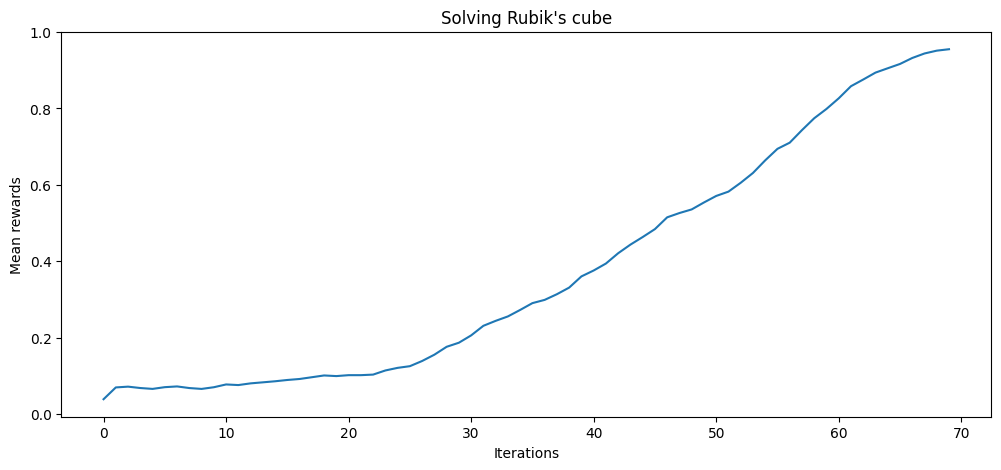

In [20]:
plot_rewards(rewards)

<Figure size 1600x800 with 0 Axes>

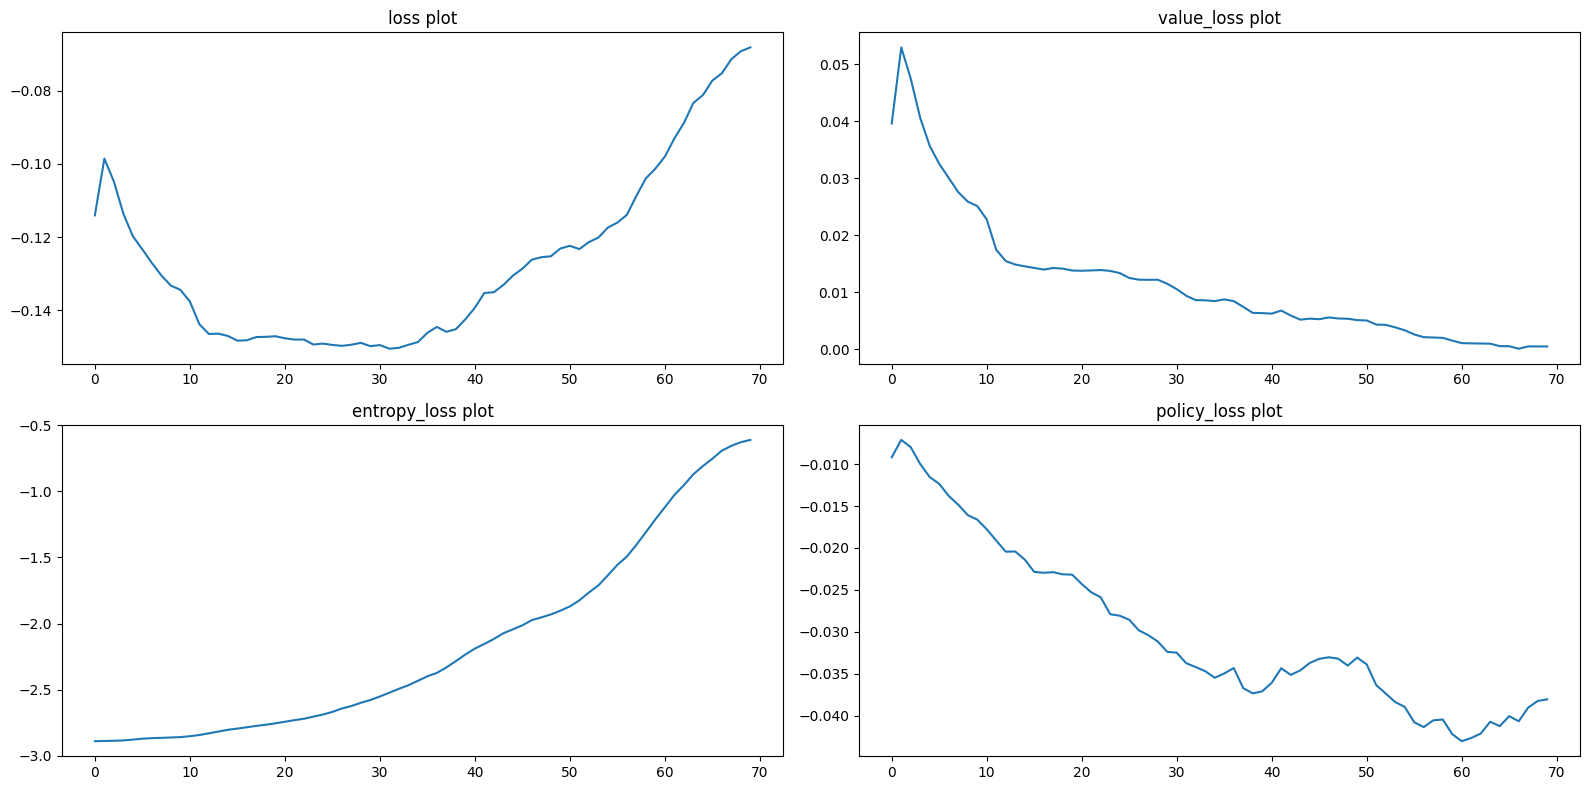

In [21]:
plot_losses(losses)

# Train

In [45]:
def train_n_scrambled_cube(n_scrambles, num_iteration, max_iter_steps, seed=10, checkpoint=25):
  rng_key = jax.random.PRNGKey(seed)
  if (isinstance(n_scrambles, int)):
    print(f"[INFO] Training on {n_scrambles} scrambled Rubik's cube")
  else:
    print(f"[INFO] Training on multi-steps scrambled Rubik's cube")
  ppo_trainer = PPOTrainer(
    policy_class=DiscretePPOPolicy,
    env_factory=make_env,
    agent_state_factory=_make_agent_state,
    num_iteration=num_iteration,
    num_sgd_iteration=8,
    learning_rate=0.0001,
    policy_clip=0.2,
    entropy_coefficient=0.05,
    value_coefficient=1.0,
    batch_size=100,
    num_batches=4,
    discount_gamma=0.99,
    gae_lambda=0.95,
    value_clip=0.1,
    use_gae=True,
    apply_value_clipping=True,
    checkpoint_freq=checkpoint,
    deque_length=10,
    max_iter_steps=max_iter_steps,
    render=False,
    n_scrambles_param=n_scrambles
  )
  ppo_trainer.train(rng_key)

  if (isinstance(n_scrambles, int)):
    print(f"[INFO] Finished Training on {n_scrambles} scrambled Rubik's cube")
  else:
    print(f"[INFO] Finished Training on multi-steps scrambled Rubik's cube")

  return ppo_trainer

# Multiple steps scrambled cubes

## 1 time scramble

In [ ]:
trainer_1 = train_n_scrambled_cube(n_scrambles=1, num_iteration=300, max_iter_steps=5)
rewards_1, losses_1 = trainer_1.get_record()

[INFO] Training on 1 scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.71
Iteration 100...
Iteration mean reward: 1.00
Iteration 150...
Iteration mean reward: 0.99
Iteration 200...
Iteration mean reward: 0.95
Iteration 250...
Iteration mean reward: 0.99
Iteration 300...
Iteration mean reward: 0.99
[INFO] Finished 1 scrambled Rubik's cube


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


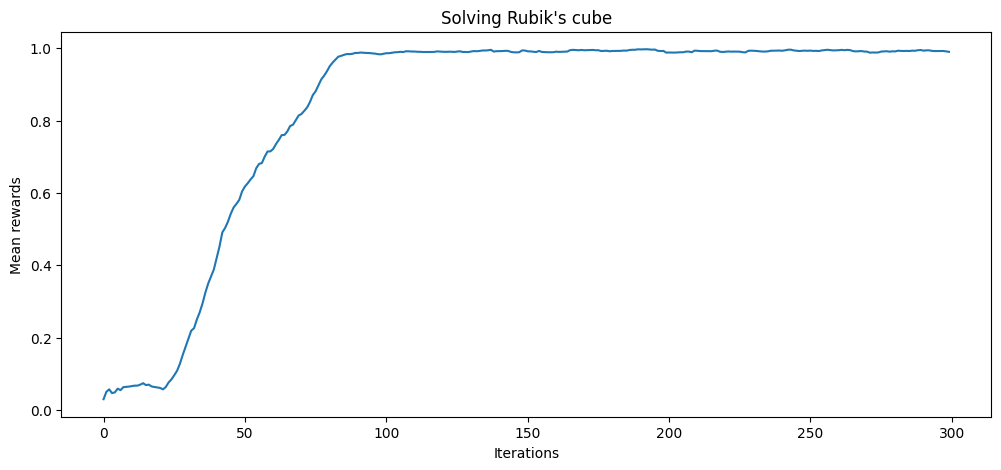

In [ ]:
plot_rewards(rewards_1)

<Figure size 1600x800 with 0 Axes>

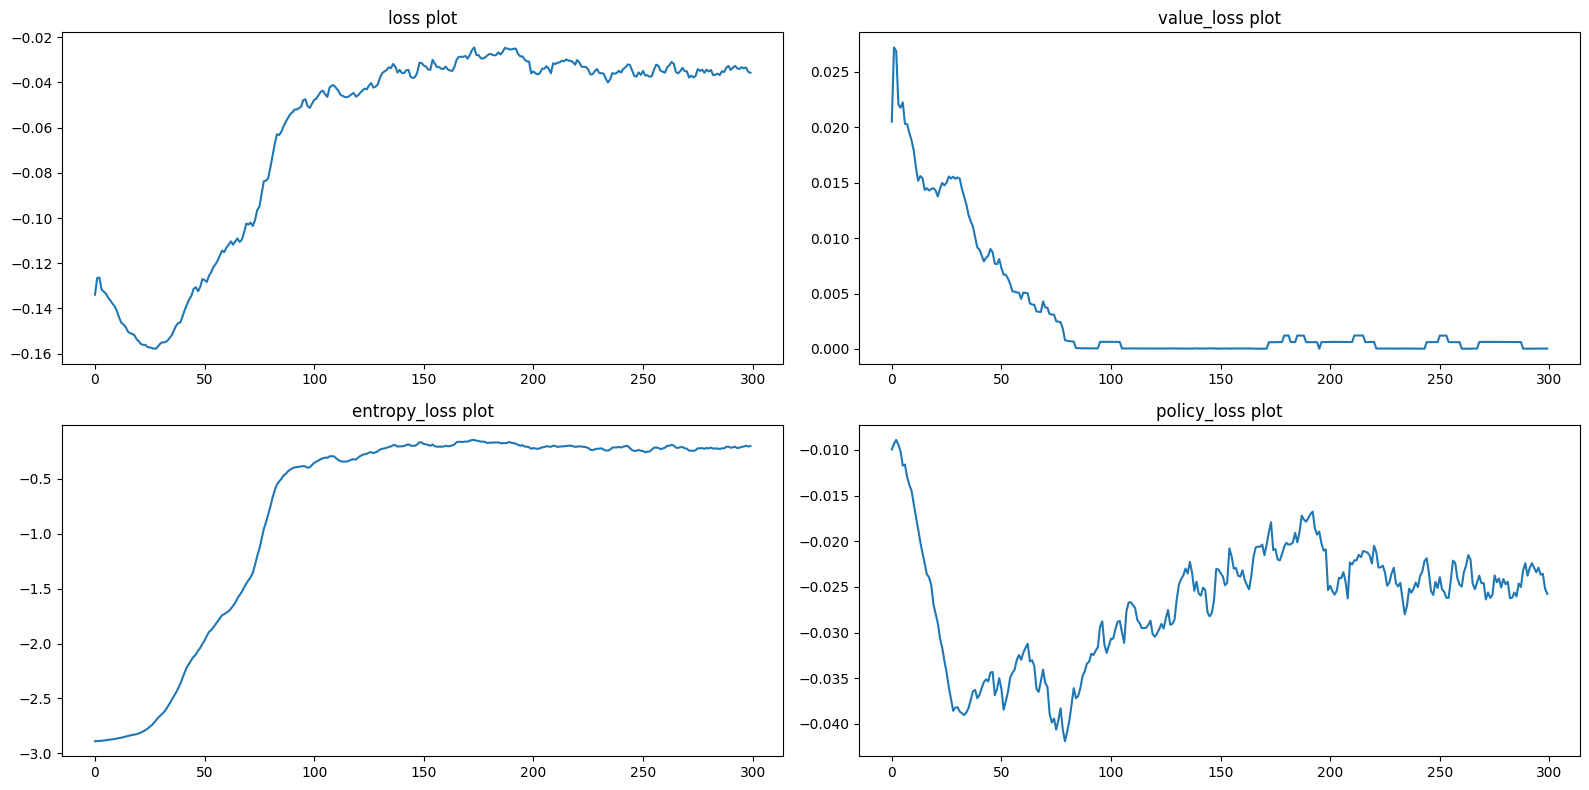

In [ ]:
plot_losses(losses_1)

## 2 times scramble

In [ ]:
trainer_2 = train_n_scrambled_cube(n_scrambles=2, num_iteration=300, max_iter_steps=5)
rewards_2, losses_2 = trainer_2.get_record()

[INFO] Training on 2 scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.14
Iteration 100...
Iteration mean reward: 0.23
Iteration 150...
Iteration mean reward: 0.36
Iteration 200...
Iteration mean reward: 0.65
Iteration 250...
Iteration mean reward: 0.70
Iteration 300...
Iteration mean reward: 0.79
[INFO] Finished 2 scrambled Rubik's cube


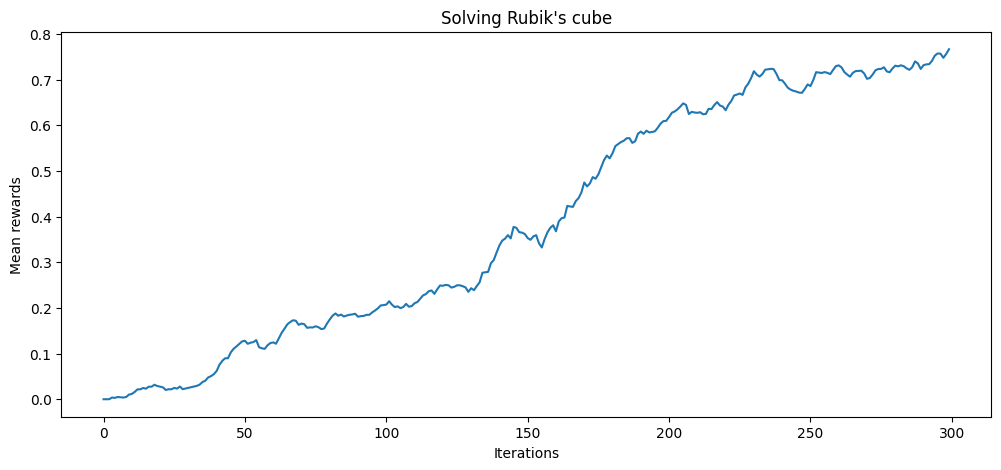

In [ ]:
plot_rewards(rewards_2)

<Figure size 1600x800 with 0 Axes>

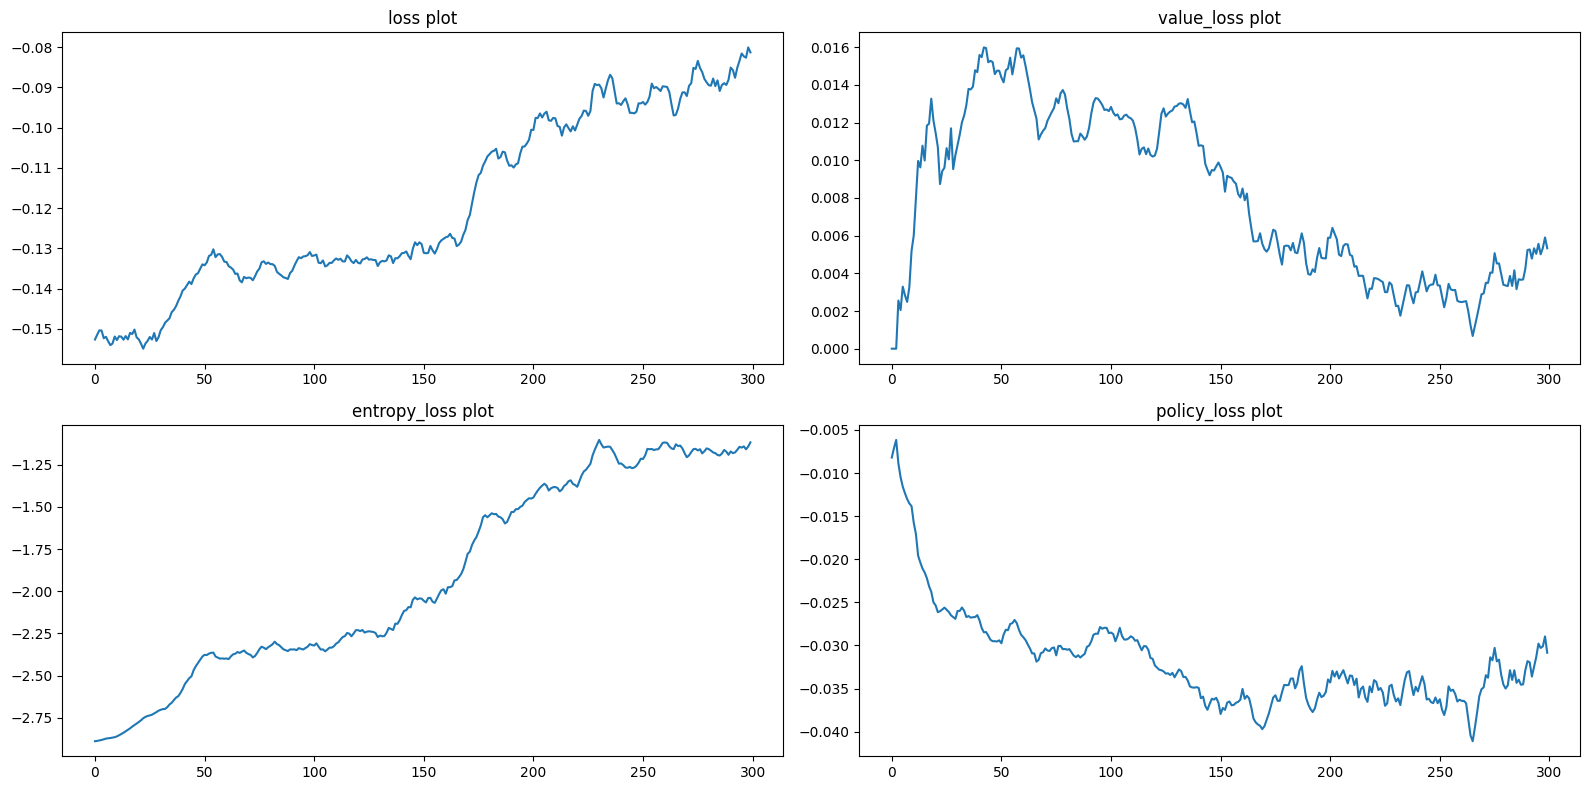

In [ ]:
plot_losses(losses_2)

## 3 times scramble

In [50]:
trainer_3 = train_n_scrambled_cube(n_scrambles=3, num_iteration=400, max_iter_steps=5, checkpoint=50)
rewards_3, losses_3 = trainer_3.get_record()

[INFO] Training on 3 scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.00
Iteration 100...
Iteration mean reward: 0.07
Iteration 150...
Iteration mean reward: 0.16
Iteration 200...
Iteration mean reward: 0.22
Iteration 250...
Iteration mean reward: 0.29
Iteration 300...
Iteration mean reward: 0.38
Iteration 350...
Iteration mean reward: 0.31
Iteration 400...
Iteration mean reward: 0.40
[INFO] Finished Training on 3 scrambled Rubik's cube


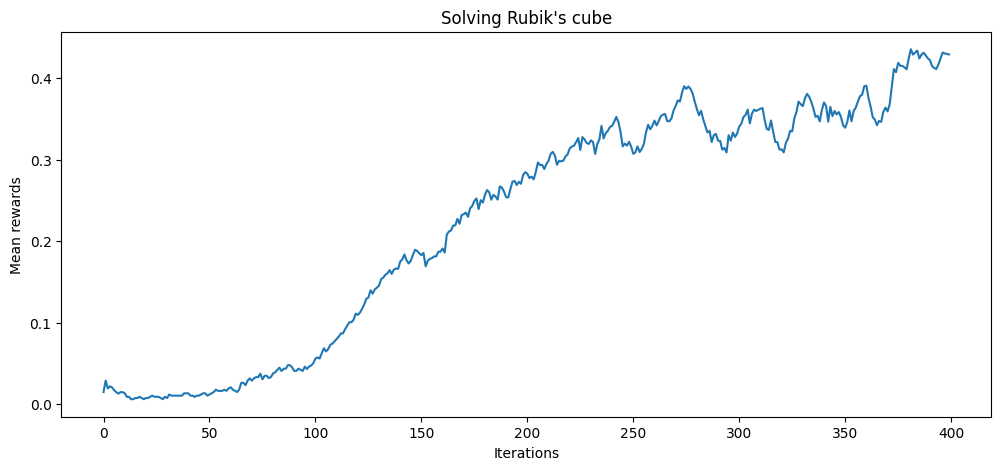

In [51]:
plot_rewards(rewards_3)

<Figure size 1600x800 with 0 Axes>

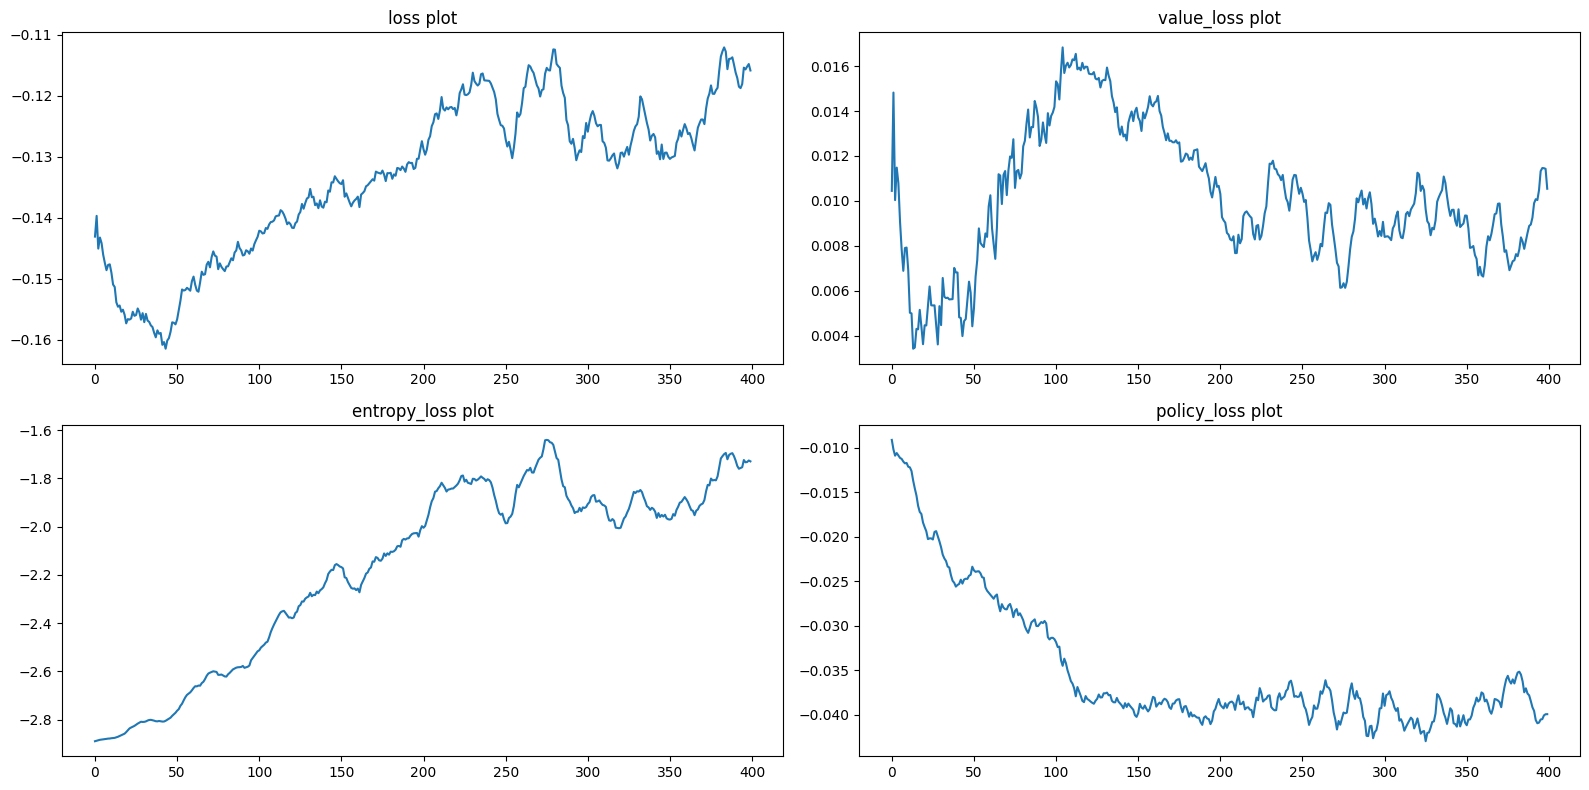

In [52]:
plot_losses(losses_3)

## 5 times scramble

In [ ]:
trainer_5 = train_n_scrambled_cube(n_scrambles=5, num_iteration=1000, max_iter_steps=8, checkpoint=50)
rewards_5, losses_5 = trainer_5.get_record()

[INFO] Training on 5 scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.00
Iteration 100...
Iteration mean reward: 0.00
Iteration 150...
Iteration mean reward: 0.00
Iteration 200...
Iteration mean reward: 0.00
Iteration 250...
Iteration mean reward: 0.00
Iteration 300...
Iteration mean reward: 0.00
Iteration 350...
Iteration mean reward: 0.00
Iteration 400...
Iteration mean reward: 0.00
Iteration 450...
Iteration mean reward: 0.00
Iteration 500...
Iteration mean reward: 0.00
Iteration 550...
Iteration mean reward: 0.00
Iteration 600...
Iteration mean reward: 0.00
Iteration 650...
Iteration mean reward: 0.00
Iteration 700...
Iteration mean reward: 0.00
Iteration 750...
Iteration mean reward: 0.00
Iteration 800...
Iteration mean reward: 0.02
Iteration 850...
Iteration mean reward: 0.00
Iteration 900...
Iteration mean reward: 0.00
Iteration 950...
Iteration mean reward: 0.00
Iteration 1000...
Iteration mean reward: 0.00
[INFO] Finished Training on 5 scrambled Rubik's cube


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


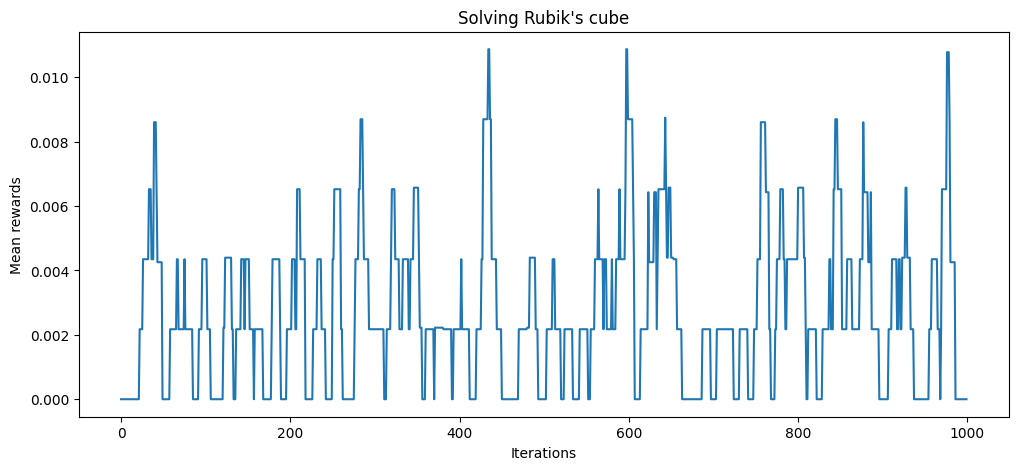

In [ ]:
plot_rewards(rewards_5)

<Figure size 1600x800 with 0 Axes>

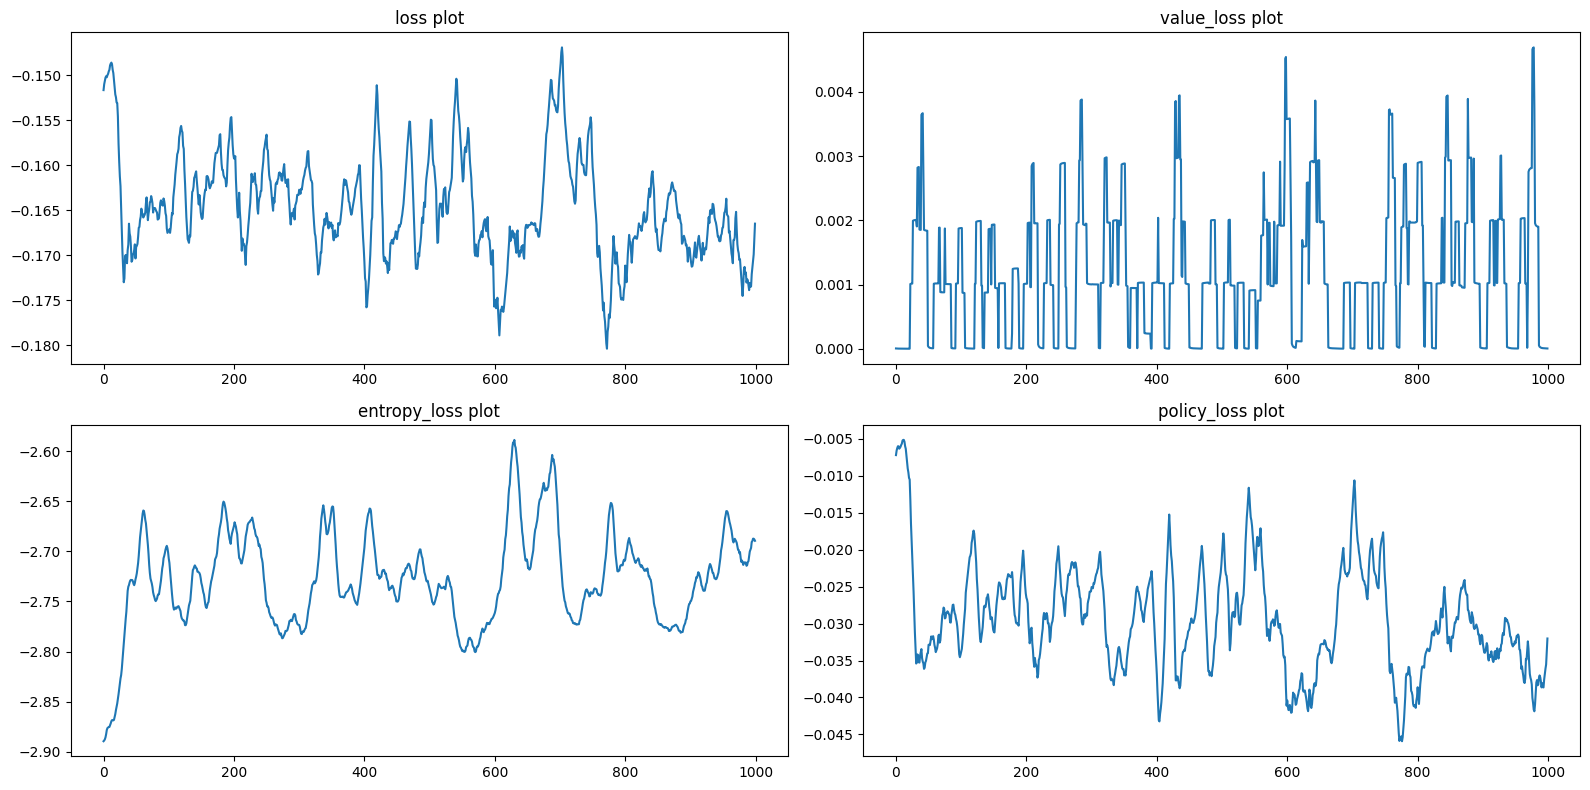

In [ ]:
plot_losses(losses_5)

## Comaparative evaluation

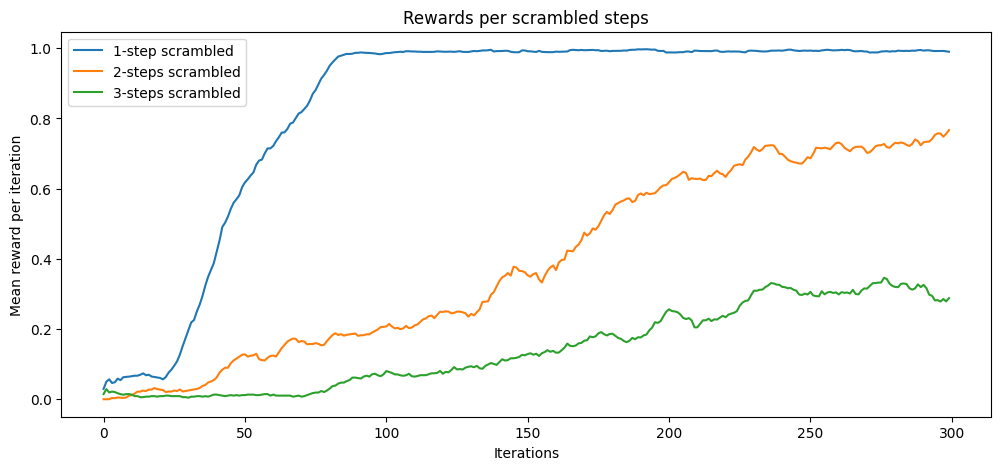

In [ ]:
iterations = range(len(rewards_1))

plt.figure(figsize=(12, 5))

plt.plot(iterations, rewards_1, label='1-step scrambled')
plt.plot(iterations, rewards_2, label='2-steps scrambled')
plt.plot(iterations, rewards_3, label='3-steps scrambled')

plt.xlabel('Iterations')
plt.ylabel('Mean reward per iteration')
plt.title('Rewards per scrambled steps')
plt.legend()

plt.show()

<Figure size 2000x800 with 0 Axes>

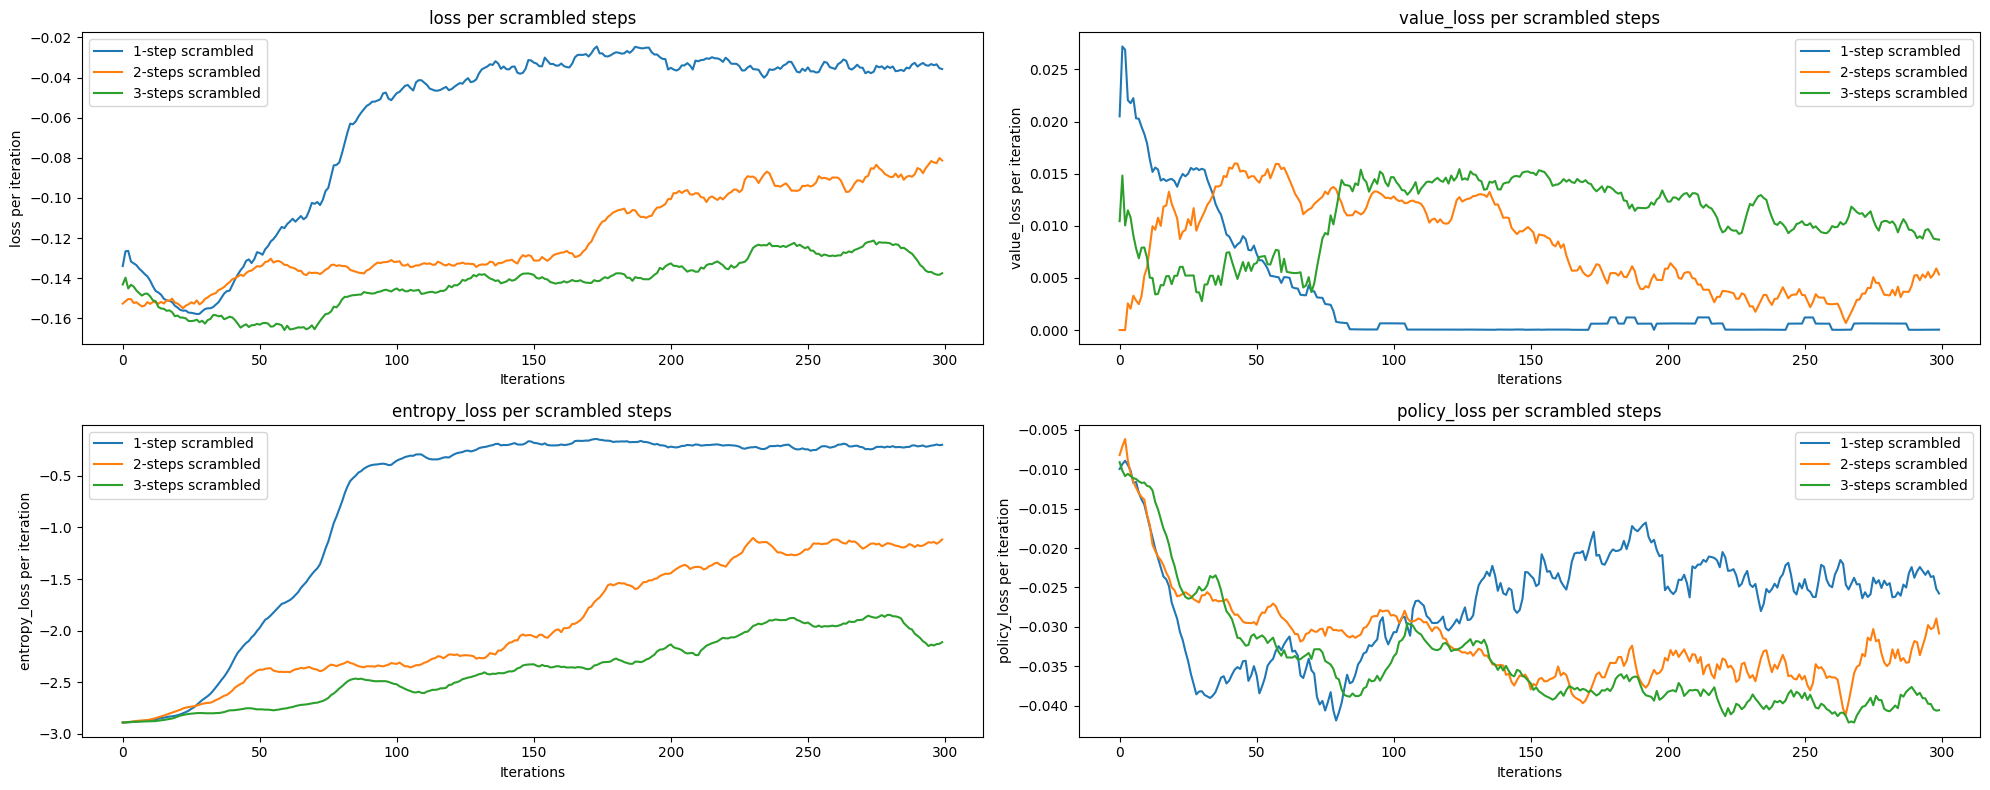

In [ ]:
iterations = range(len(losses_1['loss']))
figsize = (20, 8)

plt.figure(figsize=figsize)
fig, axes = plt.subplots(2, 2, figsize=figsize)

for i, split in enumerate(losses_1.keys()):
  axes[i//2, i%2].plot(iterations, losses_1[split], label='1-step scrambled')
  axes[i//2, i%2].plot(iterations, losses_2[split], label='2-steps scrambled')
  axes[i//2, i%2].plot(iterations, losses_3[split], label='3-steps scrambled')

  axes[i//2, i%2].set_xlabel('Iterations')
  axes[i//2, i%2].set_ylabel(f'{split} per iteration')
  axes[i//2, i%2].set_title(f'{split} per scrambled steps')
  axes[i//2, i%2].legend()

plt.tight_layout()
plt.show()

# CL

In [46]:
scrambles = {
    "1": 75,
    "2": 100,
    "3": 225,
    # "4": 400,
    # "5": 500
}

max_steps = {
    "1": 3,
    "2": 4,
    "3": 5,
    # "4": 6,
    # "5": 8
}

n_scrambles_cl = []
max_iter_steps = []

for i in scrambles.keys():
  for j in range(scrambles[i]):
    n_scrambles_cl.append(int(i))
    max_iter_steps.append(max_steps[i])

n_scrambles_cl = jnp.array(n_scrambles_cl)
max_iter_steps = jnp.array(max_iter_steps)

In [47]:
trainer_cl = train_n_scrambled_cube(n_scrambles=n_scrambles_cl, num_iteration=400, max_iter_steps=max_iter_steps, checkpoint=50)
rewards_cl, losses_cl = trainer_cl.get_record()

[INFO] Training on multi-steps scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.49
Iteration 100...
Iteration mean reward: 0.74
Iteration 150...
Iteration mean reward: 0.86
Iteration 200...
Iteration mean reward: 0.56
Iteration 250...
Iteration mean reward: 0.54
Iteration 300...
Iteration mean reward: 0.62
Iteration 350...
Iteration mean reward: 0.65
Iteration 400...
Iteration mean reward: 0.62
[INFO] Finished Training on multi-steps scrambled Rubik's cube


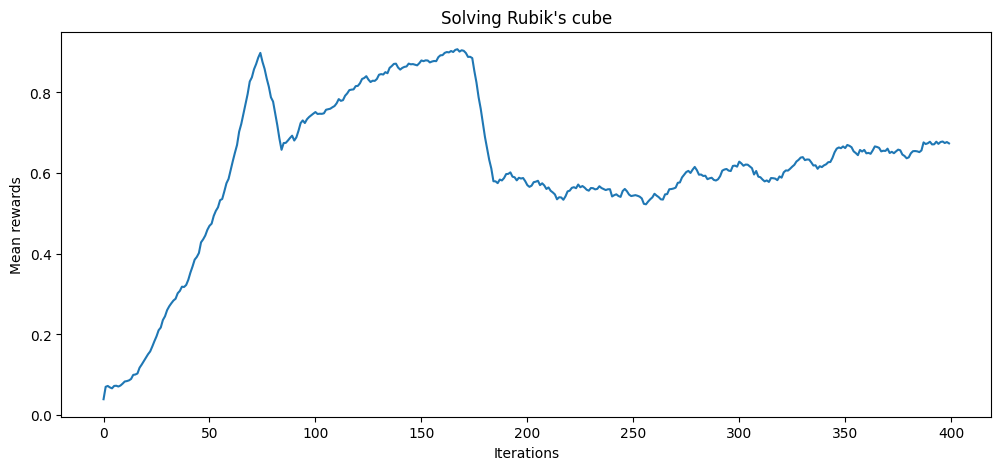

In [48]:
plot_rewards(rewards_cl)

<Figure size 1600x800 with 0 Axes>

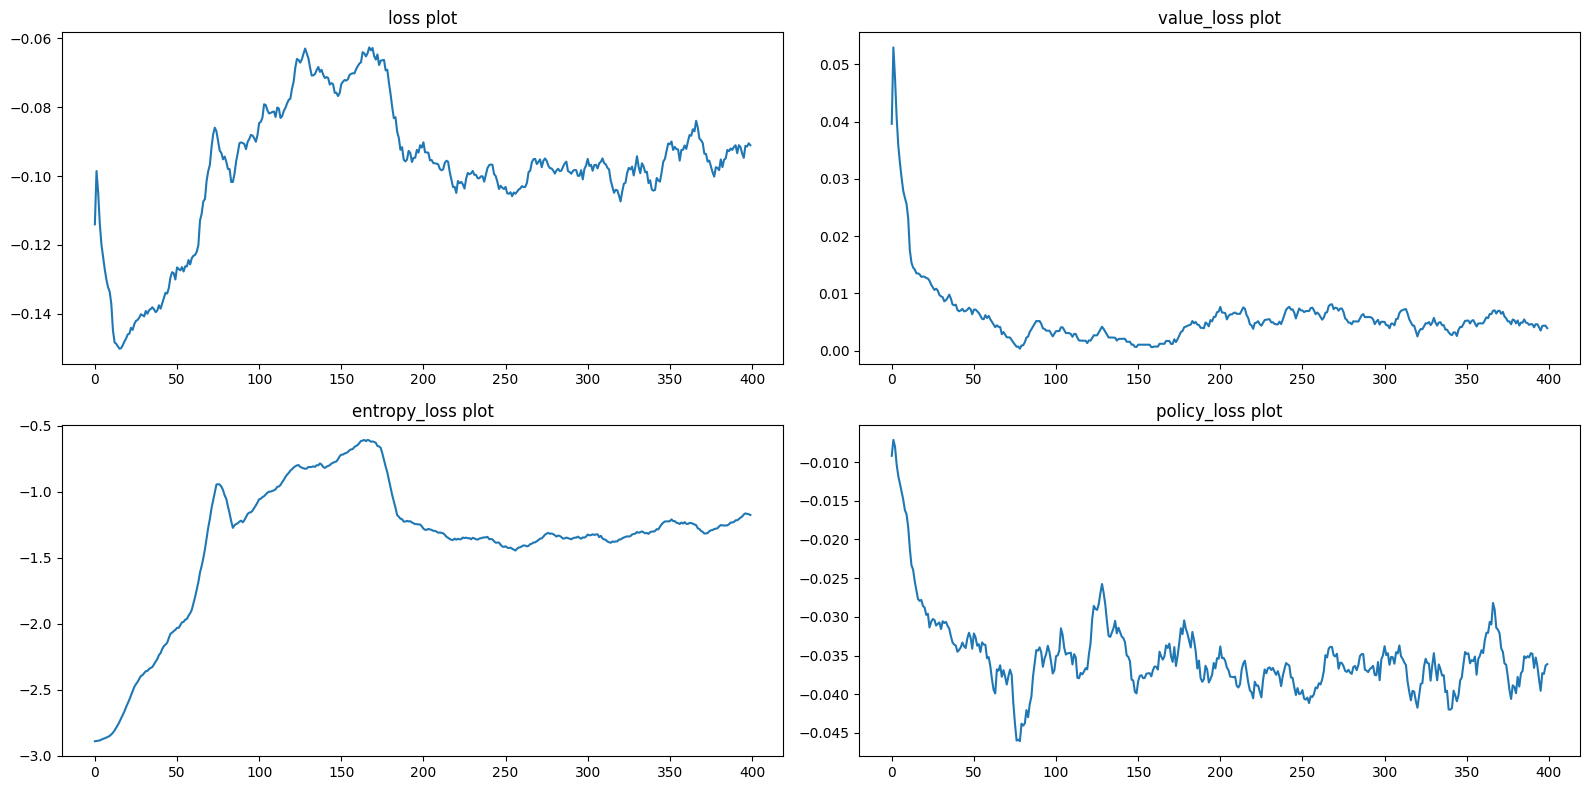

In [49]:
plot_losses(losses_cl)

In [ ]:
print(trainer_cl._agent_state_factory)

<function _make_agent_state at 0x7864ab7d8e50>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
